<a href="https://colab.research.google.com/github/tnwls6865/CAU_mAI/blob/main/Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Linear Classifier with Regularization

In [3]:

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms


In [4]:
# 데이터 변환 파이프라인 정의: 이미지를 텐서로 변환하고, 각 채널을 0.5로 정규화
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 배치 사이즈 설정
batch_size = 4

# CIFAR10 학습 데이터셋 로드 (이미지 변환 적용)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 학습 데이터 로더 설정
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# CIFAR10 테스트 데이터셋 로드 (이미지 변환 적용)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 테스트 데이터 로더 설정
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# CIFAR10 데이터셋의 클래스 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

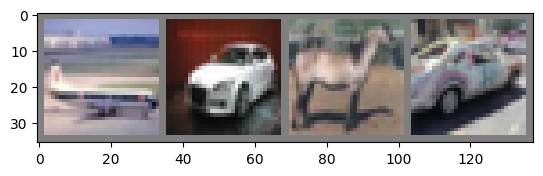

plane car   horse car  


In [ ]:

# 이미지를 화면에 보여주는 함수 정의 (unnormalize)
def imshow(img):
    img = img / 2 + 0.5     # 정규화된 이미지를 원래 값으로 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) -> (H, W, C)로 변환하여 표시
    plt.show()


# 랜덤 학습 이미지 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지를 화면에 보여줌
imshow(torchvision.utils.make_grid(images))
# 라벨 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# 학습 데이터셋과 테스트 데이터셋을 각각 배열로 변환하기 위해 리스트 초기화
X_train, y_train = [], []
X_test, y_test = [], []

# 학습 데이터셋을 이미지 데이터를 numpy 배열로 변환하여 X_train과 y_train에 저장
for i, (X, y) in enumerate(trainset):
    X_train.append(np.array(X))
    y_train.append(np.array(y))

In [ ]:

# 학습 데이터셋 크기 출력
print(len(X_train))
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

50000
(50000, 3, 32, 32)
(50000,)


In [ ]:

# 테스트 데이터셋을 이미지 데이터를 numpy 배열로 변환하여 X_test와 y_test에 저장
for i, (X, y) in enumerate(testset):
    X_test.append(np.array(X))
    y_test.append(np.array(y))

print(len(X_test))
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

10000
(10000, 3, 32, 32)
(10000,)


In [ ]:
# 데이터셋을 분할하여 학습, 검증, 테스트 세트로 나눔
num_training = 49000
num_validation = 1000
num_test = 1000

# 검증 데이터 분리
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]
# 학습 데이터 분리
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
# 테스트 데이터 분리
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:

# 데이터 전처리: 이미지 데이터를 행(row) 형태로 변환
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)


Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


In [ ]:

# 데이터에 편향(bias) 추가 (모든 데이터에 1 추가)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

(49000, 3073) (1000, 3073) (1000, 3073)


In [ ]:
# 선형 분류기 클래스 정의
class LinearClassifier(object):
    def __init__(self):
        self.W = None # 가중치 초기화

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
                batch_size=200, verbose=False):

        num_train, dim = X.shape
        num_classes = np.max(y) + 1  # 클래스의 수를 0 ~ K-1로 가정
        if self.W is None:
            # 가중치 초기화 (랜덤 값으로 초기화)
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # 배치 경사 하강법(Gradient Descent) 실행하여 W 최적화
        loss_history = []
        for it in range(num_iters):
            # 전체 데이터셋에 대해 손실과 그라디언트 계산
            loss, grad = self.loss(X, y, reg)
            loss_history.append(loss)

            # 가중치 업데이트 (Gradient Descent)
            self.W -= learning_rate * grad

            # 손실 값 출력
            if verbose and it % 10 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        # 주어진 데이터 X에 대해 예측 값 반환
        y_pred = np.zeros(X.shape[1])
        y_pred = np.argmax(np.dot(X, self.W), axis=1)

        return y_pred

    def loss(self, W, X_batch, y_batch, reg):

        pass

In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
  # 손실과 기울기 초기화
  N = X.shape[0]
  loss = 0.0
  dW = np.zeros_like(W)

  # 순전파 (forward)
  score = np.dot(X, W)   # (N, C) : X와 W의 행렬 곱을 통해 점수 계산 (N개의 샘플, C개의 클래스)
  out = np.exp(score)    # 점수를 지수 함수로 변환
  out /= np.sum(out, axis=1, keepdims=True)   # (N, C) : 각 샘플에 대해 소프트맥스 확률 계산
  loss -= np.sum(np.log(out[np.arange(N), y]))  # 실제 정답 클래스에 해당하는 소프트맥스 확률의 로그 값을 손실로 더함
  loss /= N  # 데이터 샘플 수로 평균 손실 계산

  loss += 0.5 * reg * np.sum(W**2)  # 가중치에 대한 정규화 항(reg)이 추가된 손실 계산

  # 역전파 (backward)
  dout = np.copy(out)
  dout[np.arange(N), y] -= 1  # 실제 정답 클래스에 해당하는 위치에서 1을 빼줌 (크로스 엔트로피 손실의 기울기)
  dW = np.dot(X.T, dout)
  dW /= N  # 데이터 샘플 수로 평균 기울기 계산

  dW += reg * W  # 기울기에 가중치 정규화 항(reg) 추가

  return loss, dW

In [ ]:
# Softmax 분류기
class Softmax(LinearClassifier):
    """ 다중 클래스 SVM 손실 함수를 사용하는 클래스 """
    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


In [ ]:
# Softmax 분류기 학습
softmax = Softmax()
loss_hist = softmax.train(X_train, y_train.flatten(), learning_rate=1e-5, reg=5e4, num_iters=100, verbose=True)


iteration 0 / 300: loss 758.157154
iteration 10 / 300: loss 2.303254
iteration 20 / 300: loss 2.302533
iteration 30 / 300: loss 2.302533
iteration 40 / 300: loss 2.302533
iteration 50 / 300: loss 2.302533
iteration 60 / 300: loss 2.302533
iteration 70 / 300: loss 2.302533
iteration 80 / 300: loss 2.302533
iteration 90 / 300: loss 2.302533
iteration 100 / 300: loss 2.302533
iteration 110 / 300: loss 2.302533
iteration 120 / 300: loss 2.302533
iteration 130 / 300: loss 2.302533
iteration 140 / 300: loss 2.302533
iteration 150 / 300: loss 2.302533
iteration 160 / 300: loss 2.302533
iteration 170 / 300: loss 2.302533
iteration 180 / 300: loss 2.302533
iteration 190 / 300: loss 2.302533
iteration 200 / 300: loss 2.302533
iteration 210 / 300: loss 2.302533
iteration 220 / 300: loss 2.302533
iteration 230 / 300: loss 2.302533
iteration 240 / 300: loss 2.302533
iteration 250 / 300: loss 2.302533
iteration 260 / 300: loss 2.302533
iteration 270 / 300: loss 2.302533
iteration 280 / 300: loss 2.3

In [ ]:
# 학습 데이터에 대한 예측 정확도 계산
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

# 검증 데이터에 대한 예측 정확도 계산
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.238449
validation accuracy: 0.249000


## Pytorch를 활용하여 Linear Classifier

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np

### 데이터 설정

In [7]:
# 데이터 변환 파이프라인 정의: 이미지를 텐서로 변환하고, 각 채널을 0.5로 정규화
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 배치 사이즈 설정
batch_size = 4

# CIFAR10 학습 데이터셋 로드 (이미지 변환 적용)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 학습 데이터 로더 설정
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# CIFAR10 테스트 데이터셋 로드 (이미지 변환 적용)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 테스트 데이터 로더 설정
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# CIFAR10 데이터셋의 클래스 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

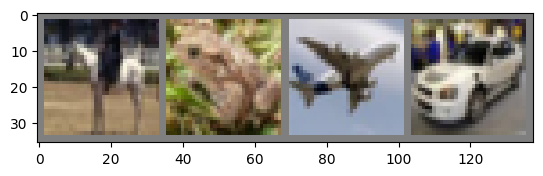

horse frog  plane car  


In [9]:
# 이미지를 화면에 보여주는 함수 정의 (unnormalize)
def imshow(img):
    img = img / 2 + 0.5     # 정규화된 이미지를 원래 값으로 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) -> (H, W, C)로 변환하여 표시
    plt.show()


# 랜덤 학습 이미지 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지를 화면에 보여줌
imshow(torchvision.utils.make_grid(images))
# 라벨 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 모델 정의

In [10]:
# 간단한 선형 분류기 모델 정의
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)  # CIFAR-10 이미지 크기 32x32x3, 출력 10 클래스

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # 이미지를 1차원으로 변환
        x = self.linear(x)
        return x

# 모델 초기화
model = LinearClassifier()

### 손실 함수 및 학습률 정의

In [6]:
# 손실 함수 (Softmax + Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01

### Gradient Descent로 업데이트 하는 학습 함수 정의

In [ ]:
def train_model_with_gradient_descent(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            model.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 수동으로 가중치 업데이트 (Gradient Descent)
            with torch.no_grad():  # autograd를 끄고 수동으로 업데이트
                for param in model.parameters():
                    param -= learning_rate * param.grad  # Gradient Descent 업데이트

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

In [ ]:
def test_model():
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

In [ ]:
print("Training with Gradient Descent")
train_model_with_gradient_descent(num_epochs=5)
test_model()

Training with Gradient Descent
[Epoch 1, Batch 100] Loss: 2.064
[Epoch 1, Batch 200] Loss: 2.144
[Epoch 1, Batch 300] Loss: 2.130
[Epoch 1, Batch 400] Loss: 2.086
[Epoch 1, Batch 500] Loss: 2.048
[Epoch 1, Batch 600] Loss: 2.141
[Epoch 1, Batch 700] Loss: 2.330
[Epoch 1, Batch 800] Loss: 2.184
[Epoch 1, Batch 900] Loss: 2.048
[Epoch 1, Batch 1000] Loss: 2.194
[Epoch 1, Batch 1100] Loss: 2.169
[Epoch 1, Batch 1200] Loss: 2.164
[Epoch 1, Batch 1300] Loss: 2.064
[Epoch 1, Batch 1400] Loss: 2.184
[Epoch 1, Batch 1500] Loss: 2.174
[Epoch 1, Batch 1600] Loss: 1.950
[Epoch 1, Batch 1700] Loss: 2.076
[Epoch 1, Batch 1800] Loss: 2.124
[Epoch 1, Batch 1900] Loss: 2.162
[Epoch 1, Batch 2000] Loss: 2.157
[Epoch 1, Batch 2100] Loss: 2.220
[Epoch 1, Batch 2200] Loss: 2.113
[Epoch 1, Batch 2300] Loss: 2.173
[Epoch 1, Batch 2400] Loss: 2.167
[Epoch 1, Batch 2500] Loss: 2.242
[Epoch 1, Batch 2600] Loss: 2.271
[Epoch 1, Batch 2700] Loss: 2.111
[Epoch 1, Batch 2800] Loss: 2.036
[Epoch 1, Batch 2900] Loss

### Stochastic Gradient Descent (SGD)
장점: 빠르게 기울기를 계산하고, 큰 데이터셋에서도 효율적입니다.   
단점: 기울기의 노이즈가 커서 손실 함수가 급격하게 진동할 수 있으며, 안정적으로 수렴하는 데 시간이 걸릴 수 있습니다.

In [ ]:

# 배치 사이즈 설정
batch_size = 4

# CIFAR10 학습 데이터셋 로드 (이미지 변환 적용)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 학습 데이터 로더 설정
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# CIFAR10 테스트 데이터셋 로드 (이미지 변환 적용)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 테스트 데이터 로더 설정
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [56]:
# SGD 옵티마이저 설정
optimizer = optim.SGD(model.parameters(), lr=0.01)

### SGD로 업데이트 하는 학습 함수 정의

In [ ]:
def train_model_with_sgd(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            optimizer.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 파라미터 업데이트
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

### SGD + Momentum
진동 감소와 빠른 수렴이 가능합니다.  
급격한 진동을 억제하고 안정된 학습 진행이 가능합니다.  
평탄한 방향에서의 학습 가속을 할 수 있습니다.  
지역 최솟값에 갇히는 것 방지가 가능합니다.

In [57]:
# Momentum을 포함한 SGD 설정
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train_model_with_momentum(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            optimizer.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 파라미터 업데이트
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

### Adam Optimizer
장점: 적응형 학습률 덕분에 학습이 더 빠르고, 지역 최솟값에 갇히는 문제를 완화할 수 있음  
 모멘트의 활용으로 기울기 진동을 줄여 안정적인 학습이 가능

단점: 복잡한 최적화 문제에서는 간혹 과적합이나 학습이 불안정할 수 있어, 학습률을 신중히 조정해야 함

In [58]:
# Adam 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model_with_adam(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            optimizer.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 파라미터 업데이트
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

### RMSprop Optimizer
장점:기울기가 크거나 작은 방향에서 학습률을 자동으로 조정하므로, 학습이 더 효율적이고 안정적임    
   AdaGrad와 달리 학습이 진행되면서 학습 속도가 지나치게 감소하지 않도록 설계되어 있음

 단점:학습률을 신중하게 설정해야 함
     적절한 학습률을 선택하지 않으면 수렴 속도가 느리거나 학습이 불안정할 수 있음

In [59]:
# RMSprop 옵티마이저 설정
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [60]:
def train_model_with_rnsprop(num_epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # 순전파 (Forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 모든 가중치의 기울기(gradient)를 0으로 설정
            optimizer.zero_grad()

            # 역전파 (Backward)
            loss.backward()

            # 파라미터 업데이트
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 100 == 99:    # 100 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0
    print('Finished Training')

다양한 optimizer에 대해 loss 및 성능 비교

In [18]:
# 옵티마이저를 생성하는 함수를 정의 (모델을 인자로 받아 새로운 옵티마이저 생성)
def get_optimizer(name, model):
    if name == 'SGD':
        return optim.SGD(model.parameters(), lr=0.01)
    elif name == 'SGD+Momentum':
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif name == 'Adam':
        return optim.Adam(model.parameters(), lr=0.001)
    elif name == 'RMSprop':
        return optim.RMSprop(model.parameters(), lr=0.001)

# 학습 및 테스트 함수 정의
def train_model(optimizer, model, num_epochs=10):
    model.train()  # 학습 모드 설정
    train_loss_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 순전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트

            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_loss_history.append(avg_loss)

        # 테스트 정확도 평가
        test_acc = test_model(model)
        test_acc_history.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    return train_loss_history, test_acc_history

def test_model(model):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [8]:
# 옵티마이저 별로 학습 및 테스트 실행
num_epochs = 10
results = {}

optimizer_names = ['SGD', 'SGD+Momentum', 'Adam', 'RMSprop']

for name in optimizer_names:
    print(f'\nTraining with {name} Optimizer')
    model = LinearClassifier()  # 매번 새로운 모델로 초기화
    optimizer = get_optimizer(name, model)  # 옵티마이저를 매번 새로 생성

    train_loss, test_acc = train_model(optimizer, model, num_epochs)
    results[name] = {
        'loss': train_loss,
        'accuracy': test_acc
    }



Training with SGD Optimizer
Epoch [1/10], Loss: 1.8432, Test Accuracy: 38.57%
Epoch [2/10], Loss: 1.7569, Test Accuracy: 39.23%
Epoch [3/10], Loss: 1.7280, Test Accuracy: 39.40%
Epoch [4/10], Loss: 1.7107, Test Accuracy: 40.28%
Epoch [5/10], Loss: 1.7004, Test Accuracy: 39.01%
Epoch [6/10], Loss: 1.6912, Test Accuracy: 40.16%
Epoch [7/10], Loss: 1.6847, Test Accuracy: 40.27%
Epoch [8/10], Loss: 1.6782, Test Accuracy: 38.82%
Epoch [9/10], Loss: 1.6740, Test Accuracy: 40.36%
Epoch [10/10], Loss: 1.6710, Test Accuracy: 39.44%

Training with SGD+Momentum Optimizer
Epoch [1/10], Loss: 1.9762, Test Accuracy: 34.45%
Epoch [2/10], Loss: 1.9068, Test Accuracy: 34.84%
Epoch [3/10], Loss: 1.8891, Test Accuracy: 36.41%
Epoch [4/10], Loss: 1.8832, Test Accuracy: 36.66%
Epoch [5/10], Loss: 1.8705, Test Accuracy: 35.13%
Epoch [6/10], Loss: 1.8653, Test Accuracy: 34.04%
Epoch [7/10], Loss: 1.8739, Test Accuracy: 34.18%
Epoch [8/10], Loss: 1.8509, Test Accuracy: 35.49%
Epoch [9/10], Loss: 1.8473, Test

In [ ]:
# 6. 손실(Loss) 및 정확도(Accuracy) 그래프 출력
plt.figure(figsize=(14, 6))

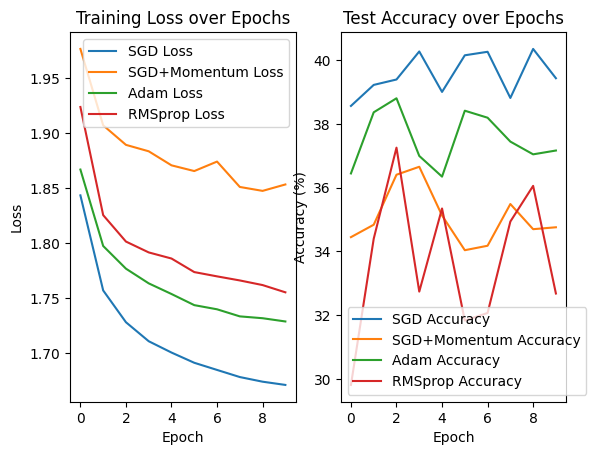

In [9]:
# Loss 그래프
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name]['loss'], label=f'{name} Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
for name in results:
    plt.plot(results[name]['accuracy'], label=f'{name} Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

### GPU 설정

In [11]:
# 모델 초기화
model = LinearClassifier()

# model.cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [12]:
print(device)

cuda


In [13]:
# 손실 함수 (Softmax + Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss().to(device)

In [15]:
# 최적화 선언
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [23]:
def train_model(optimizer, model, num_epochs=10):
    model.train()  # 학습 모드 설정
    train_loss_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 순전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트

            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_loss_history.append(avg_loss)

        # 테스트 정확도 평가
        test_acc = test_model(model)
        test_acc_history.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    return train_loss_history, test_acc_history

In [19]:
train_loss, test_acc = train_model(optimizer, model)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [22]:
def test_model(model):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [24]:
train_loss, test_acc = train_model(optimizer, model)

Epoch [1/10], Loss: 2.1230, Test Accuracy: 33.30%
Epoch [2/10], Loss: 2.0995, Test Accuracy: 33.14%
Epoch [3/10], Loss: 2.0892, Test Accuracy: 32.52%


KeyboardInterrupt: 